# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Vorbereitung**

In [5]:
# import libraries
import numpy as np
import os
from pandas import DataFrame, concat
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

import src.data_loader as dl
import src.visualization as vis
import src.model_constructor as mc

In [6]:
# set the source directory for the preprocessed data to use
SOURCE: str = "ef15f799-1a24-4d25-8a7f-1be8024534a3"

# setup a single index for control purposes
CONTROL_INDEX: int = 1

In [7]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

In [8]:
# load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "processed" / SOURCE
development_data, evaluation_data = dl.load_all_datasets(data_path)

READING DEVELOPMENT DATA
0D_0_fft.csv successfully loaded.
0D_1_fft.csv successfully loaded.
1D_0_fft.csv successfully loaded.
1D_1_fft.csv successfully loaded.
2D_0_fft.csv successfully loaded.
2D_1_fft.csv successfully loaded.
3D_0_fft.csv successfully loaded.
3D_1_fft.csv successfully loaded.
4D_0_fft.csv successfully loaded.
4D_1_fft.csv successfully loaded.
READING EVALUATION DATA
0E_0_fft.csv successfully loaded.
0E_1_fft.csv successfully loaded.
1E_0_fft.csv successfully loaded.
1E_1_fft.csv successfully loaded.
2E_0_fft.csv successfully loaded.
2E_1_fft.csv successfully loaded.
3E_0_fft.csv successfully loaded.
3E_1_fft.csv successfully loaded.
4E_0_fft.csv successfully loaded.
4E_1_fft.csv successfully loaded.
READING COMPLETED


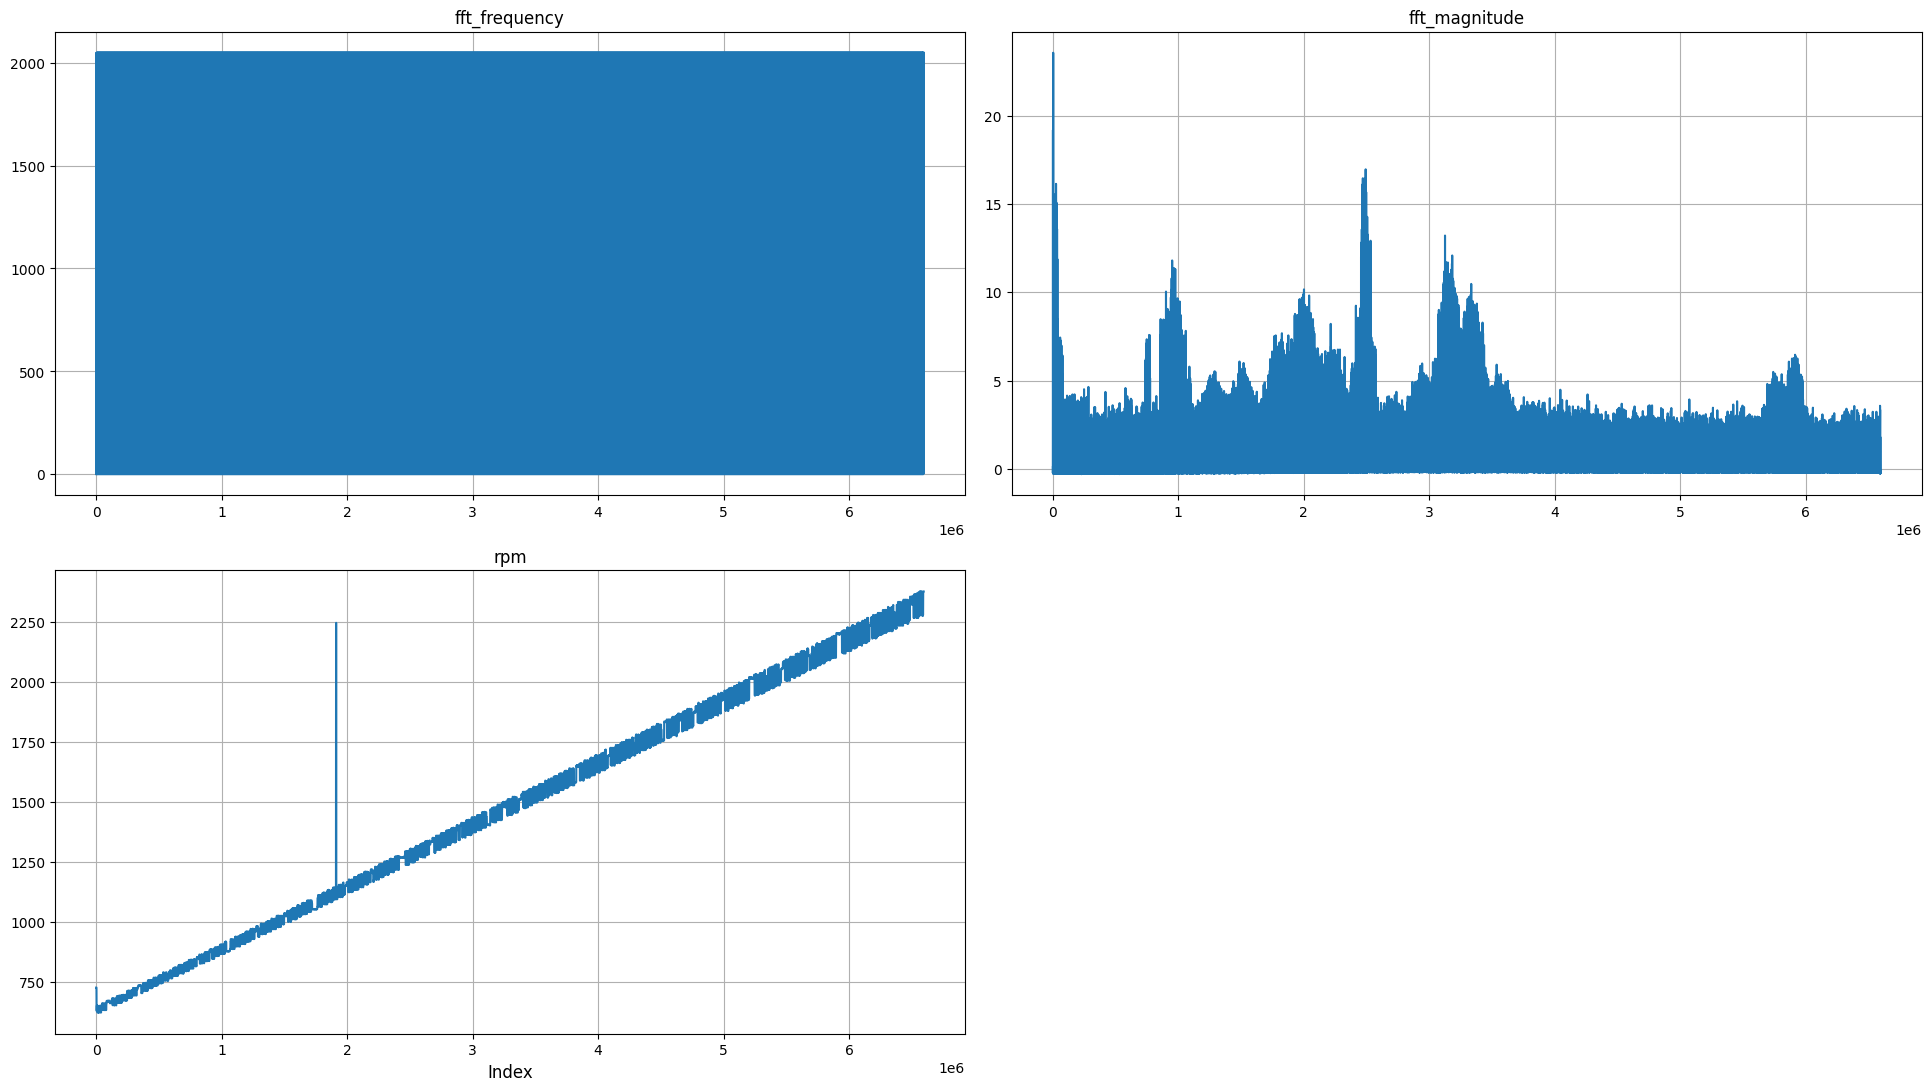

In [9]:
# visualize one random dataset for data validation
vis.plot_columns_as_subplots(development_data[CONTROL_INDEX],
                             development_data[CONTROL_INDEX].columns)

#### **Das Neuronale Netz**


Die einzelnen DataFrames der Development Data werden in einem DataFrame vereint. Anschließend konvertiert die Funktion ip.split_data() die gewählten Spalten des DataFrames in einen Input-Datensatz für das Neuronale Netz. In diesem Dictionary sind die Trainings-Daten und -Labels, sowie der Encoder, mit dem die Labels enkodiert wurden, enthalten.

In [103]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from pandas import concat

training_samples_dict = ip.split_data(full_development_dataset, ["fft_magnitude"])


index = 1
def prepare_data_for_input(datasets: list[DataFrame]):
    keys = []
    for index, dataset in enumerate(datasets):
        keys.append(dataset.attrs["path"].stem)

        # if dataset.attrs["unbalance"] == "none":
        #     dataset["label"] = "none"
        # else:
        #     dataset["label"] = "some"

        dataset["label"] = dataset.attrs["unbalance"]
        datasets[index] = dataset

    return concat(datasets, keys=keys)


ds = prepare_data_for_input(development_data)

display(ds)

training_samples = ds["fft_magnitude"].to_numpy()
training_labels = ds["label"].to_numpy()



training_samples = np.reshape(training_samples, (-1, 2048))
training_labels = np.reshape(training_labels, (-1, 2048))
training_labels = training_labels[:,0]

# encode labels

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(training_labels)
y_one_hot = to_categorical(y_encoded, num_classes=5)


training_samples, y_one_hot = shuffle_data_and_labels(training_samples, y_one_hot)

print(training_samples.shape)
print(y_one_hot.shape)

{'index_type': 'standard',
 'mass': [0.0, 3.281, 6.614],
 'mass_tolerance': [0.0, 0.003, 0.007],
 'path': [WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/0D_0_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/0D_1_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/1D_0_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/1D_1_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/2D_0_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/2D_1_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/3D_0_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/3D_1_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/4D_0_fft.csv'),
  WindowsPath('c:/Users/Studium/Documents/GitHub/ai-gear-fault-detection/data/processed/sensor_1_only/4D_1_fft.csv')],
 'radius': [0.0, 14.0, 18.5, 23.0],
 'radius_tolerance': [0.0, 0.1],
 'sample_rate': 2048,
 'sample_size': [6574080, 6594560, 6592512],
 'type': 'development',
 'unbalance': ['none', 'slight', 'moderat', 'significant', 'strong'],
 'voltage_end': 10.05,
 'voltage_start': 2.0,
 'voltage_step': 0.05}

(32148, 2048)
(32148, 5)


In [11]:
# Klassen
# Extrahieren der eindeutigen Klassenbezeichnungen
unique_classes = np.unique(training_labels)  # Eindeutige Klassen im Datensatz
class_names = [str(cls) for cls in unique_classes]  # In Strings konvertieren (optional)

print("Eindeutige Klassen im Datensatz:", class_names)

# Klassenverteilung anzeigen
class_counts = np.sum(y_one_hot, axis=0)  # Summiere jede Spalte im One-Hot-Encoding
print("Klassenverteilung:", class_counts)

Eindeutige Klassen im Datensatz: ['moderat', 'none', 'significant', 'slight', 'strong']
Klassenverteilung: [6430. 6430. 6429. 6430. 6429.]


In [12]:
LEARNING_RATE: float = 0.0001
MOMENTUM: float = 0.8 #0.9
BATCH_SIZE: int = 32 #64
EPOCHS: int = 50
THRESHOLD = 0.5 #0.95
NUMBER_OF_HIDDEN_LAYERS: int = 2

In [13]:
import keras
from keras import layers, regularizers
input_shape = training_samples.shape
output_shape = y_one_hot.shape
print(output_shape)


model = keras.Sequential()
model.add(layers.Dense(2048, input_shape=(input_shape[1],)))

# add the number of hidden layers
for _ in range(NUMBER_OF_HIDDEN_LAYERS):
    model.add(layers.Dense(units = 1024,
                           kernel_regularizer=regularizers.L2(0.001)))
    model.add(layers.LeakyReLU(negative_slope=0.3))
    model.add(layers.Dropout(0.2))
    

model.add(layers.Dense(output_shape[1], activation="sigmoid"))

model.summary()

(32148, 5)


c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,448,453 (36.04 MB)

 Trainable params: 9,448,453 (36.04 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

'''
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],
)

model.fit(x=training_samples,y=y_one_hot, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

'''


model.compile(
    # optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, name="adam"),
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss = keras.losses.CategoricalCrossentropy(), # für Multiklassen
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision", thresholds=THRESHOLD),
        keras.metrics.Recall(name="recall", thresholds=THRESHOLD),
    ],
)

history = model.fit(
    x=training_samples,
    y=y_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    shuffle=True,
    # callbacks=[early_stopping],
    class_weight=class_weights_dict
)


Epoch 1/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.2204 - loss: 2.3331 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3673 - val_loss: 1.9365 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.3472 - loss: 2.0762 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4862 - val_loss: 1.7084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.4853 - loss: 1.8213 - precision: 0.7896 - recall: 3.7974e-04 - val_accuracy: 0.5869 - val_loss: 1.4383 - val_precision: 1.0000 - val_recall: 0.0022
Epoch 4/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.6036 - loss: 1.5355 - precision: 0.9898 - recall: 0.0090 - val_accuracy: 0.7023 - val_loss: 1.2020 - val_precision: 1.0000 - val_recall: 0.0495
Epoch 5/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.7074 - loss: 1.2903 - precision: 0.9691 - r

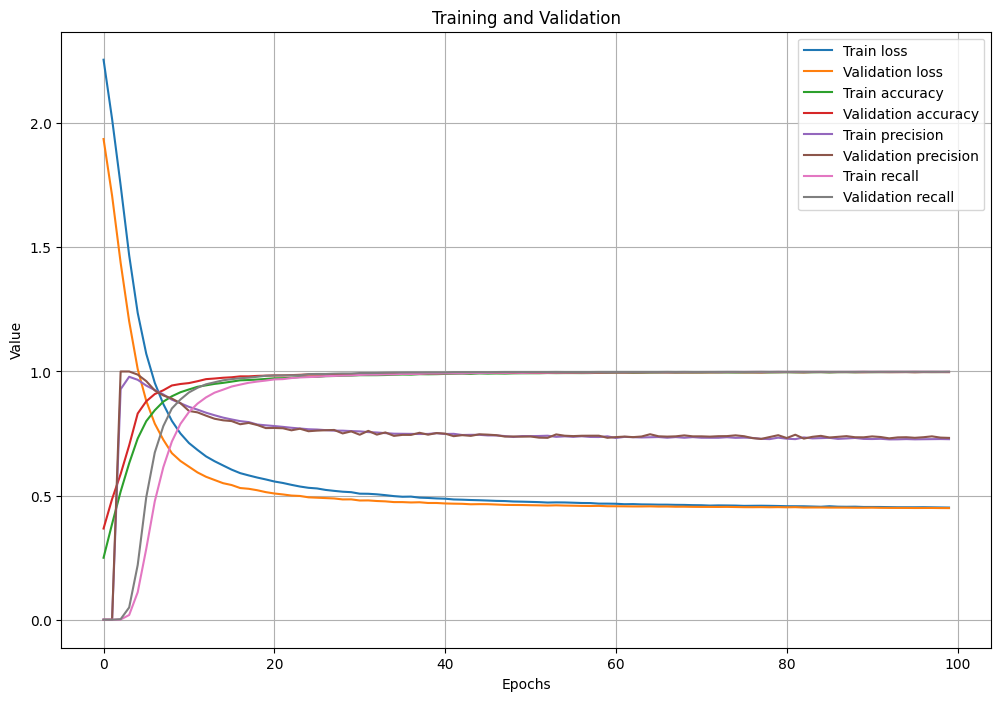

In [15]:
# visualize training metrics
vis.plot_training_history(history, metrics=["loss", "accuracy", "precision", "recall"])

In [16]:
test_dataset = prepare_data_for_input(evaluation_data)

test_samples = test_dataset["fft_magnitude"].to_numpy()
test_labels = test_dataset["label"].to_numpy()

test_samples = np.reshape(test_samples, (-1, 2048))
test_labels = np.reshape(test_labels, (-1, 2048))
test_labels = test_labels[:,0]

# encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(test_labels)
y_one_hot = to_categorical(y_encoded, num_classes=5)


test_samples, test_labels = shuffle_data_and_labels(test_samples, y_one_hot)

print(test_samples.shape)
print(test_labels.shape)

(8347, 2048)
(8347, 5)


In [17]:
print(test_labels)

# Klassenverteilung in den Testdaten
test_class_counts = np.sum(test_labels, axis=0)
print("Klassenverteilung in den Testdaten:", test_class_counts)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
Klassenverteilung in den Testdaten: [1668. 1669. 1670. 1670. 1670.]


In [18]:
evaluation = model.evaluate(test_samples, test_labels, verbose=1, return_dict=True)

display(evaluation)

predictions = model.predict(test_samples)

display(predictions)

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5489 - loss: 3.5417 - precision: 0.3942 - recall: 0.5906


{'accuracy': 0.5439079999923706,
 'loss': 3.565586805343628,
 'precision': 0.3903575837612152,
 'recall': 0.582005500793457}

In [19]:

#predictions = model.predict(test_samples) # training_samples
predicted_classes = np.argmax(predictions, axis=1)
predicted_label = encoder.inverse_transform(predicted_classes)
print(predicted_label)

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

MODEL PREDICTIONS

['moderat' 'none' 'significant' ... 'moderat' 'slight' 'slight']
['slight' 'none' 'strong' ... 'slight' 'slight' 'significant']


In [115]:
# Verifizieren, dass die Testdaten und Labels übereinstimmen
assert test_samples.shape[0] == predictions.shape[0], "Die Anzahl der Testdaten und Vorhersagen stimmen nicht überein."
assert test_samples.shape[0] == test_labels.shape[0], "Testdaten und Labels haben unterschiedliche Längen."

print("Erste Labels:", test_labels[:5])
print("Erste Vorhersagen:", predictions[:5])

Erste Labels: [[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
Erste Vorhersagen: [[4.1547374e-04 1.9619090e-02 9.8650169e-01 4.7811660e-01 9.9986821e-01]
 [9.2850554e-01 9.9525917e-01 9.8629564e-01 8.8144494e-03 1.7659312e-02]
 [9.4037277e-01 9.9204797e-01 9.8403907e-01 3.0862859e-02 4.7145458e-03]
 [7.5093523e-02 9.7901738e-01 5.8510560e-01 9.2092198e-01 2.9813254e-01]
 [8.3310056e-01 9.9998486e-01 6.7080045e-01 1.7886217e-01 1.3642992e-04]]


In [116]:
#Überprüfen 
print("Shape von test_samples:", test_samples.shape)
print("Shape von test_labels:", test_labels.shape)
print("Shape von predictions:", predictions.shape)

Shape von test_samples: (8347, 2048)
Shape von test_labels: (8347, 5)
Shape von predictions: (8347, 5)


#### Confusion Matrix
Die Confusion Matrix zeigt, wie gut dein Modell zwischen den verschiedenen Klassen unterscheidet. Jede Zelle stellt die Anzahl der Samples dar, die einer bestimmten Klasse zugeordnet wurden (wahre Labels) und wie das Modell diese Klasse vorhergesagt hat (vorhergesagte Labels).



<Figure size 800x800 with 0 Axes>

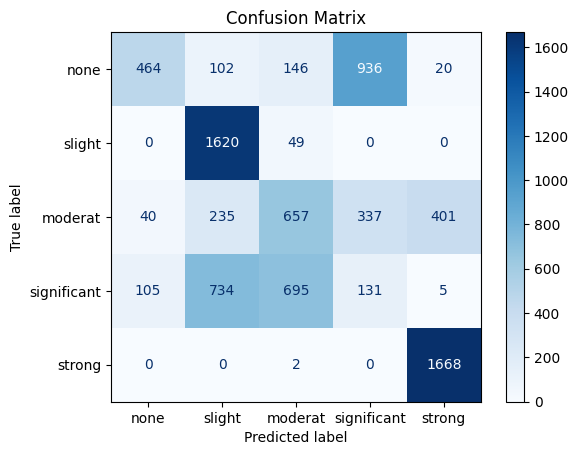

In [117]:
# Confusion Matrix:
true_labels = test_labels.argmax(axis=1)  # One-Hot-Encoding auf numerische Labels zurückführen
predicted_labels = predictions.argmax(axis=1)  # Die wahrscheinlichste Klasse auswählen

# Confusion Matrix plotten
vis.plot_confusion_matrix(true_labels, predicted_labels, class_names)